# **Algorithms for Massive Data - DSE**
## Project - Plant Leaves Recognizer
## David Fernandez - 988346

## Upload kaggle.json

In [1]:
# Upload kaggle.json file

! pip install -q kaggle
from google.colab import files
uploaded = files.upload() # browse kaggle.json file on local machine

Saving kaggle.json to kaggle.json


In [2]:
# Working directory for kaggle.json file

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


## *Install libraries and download data*

In [3]:
#Set working directory to notebook location

import os
current_dir = os.getcwd()
os.chdir(current_dir)
print(current_dir)

/content


In [4]:
# Install libraries

!pip install tensorflow==2.8.0 scikeras[tensorflow] sklearn matplotlib pandas numpy seaborn pydot graphviz scikit-image  &> /dev/null

In [5]:
# Install fonts

!apt-get install -y fonts-dejavu-core &> /dev/null

In [6]:
# Install pending libraries

!pip install scikeras visualkeras &> /dev/null

In [7]:
# Import libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import random
import cv2
import pickle
import shutil
import zipfile

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, load_model

from keras.layers import PReLU, Dense, Dropout, Activation, Flatten
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import metrics
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score
from skimage import data, color
from skimage.io import imread

import graphviz
import pydot
import visualkeras
from PIL import ImageFont
from concurrent.futures import ThreadPoolExecutor

In [8]:
# Reproducibility

session_conf = tf.compat.v1.ConfigProto( intra_op_parallelism_threads=1, inter_op_parallelism_threads=1 )
sess = tf.compat.v1.Session( graph=tf.compat.v1.get_default_graph(), config=session_conf )
tf.compat.v1.keras.backend.set_session(sess)

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [9]:
# GPU available

device_name = tf.test.gpu_device_name()

if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))


Found GPU at: /device:GPU:0


In [10]:
# Download dataset

!kaggle datasets download -d csafrit2/plant-leaves-for-image-classification

100% 6.55G/6.56G [00:48<00:00, 159MB/s]
100% 6.56G/6.56G [00:48<00:00, 144MB/s]


In [11]:
# Unzip downloaded files in 'dataset' directory

! mkdir dataset
with tf.device(device_name):
  ! unzip plant-leaves-for-image-classification.zip -d dataset &> /dev/null

In [31]:
#!rm -rf plots

## *Dataset exploration*

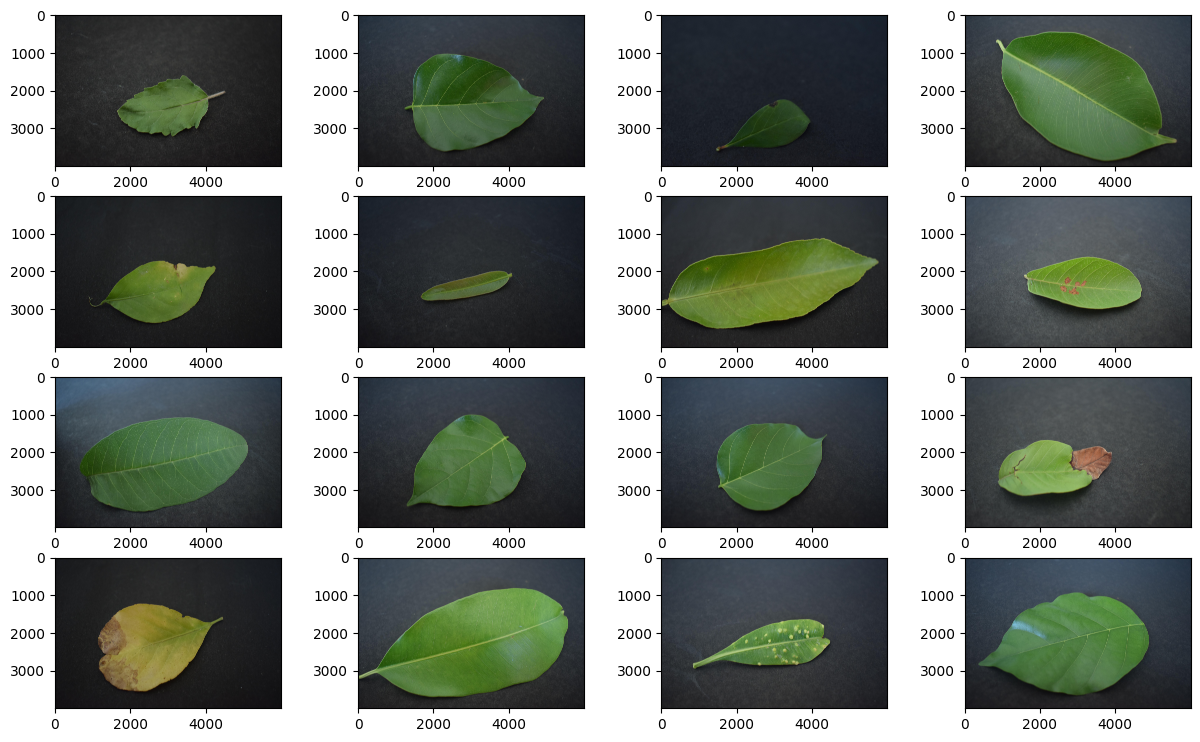

In [12]:
# Show set of random images from the training set

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

path = '/content/dataset/Plants_2/train'

with tf.device(device_name):
  images = []
  for folder in os.listdir(path):
    for image in os.listdir(path + '/' + folder):
      images.append(os.path.join(path, folder, image))
        
  plt.figure(1, figsize=(15, 9))
  n = 0
  for i in range(16):
    n += 1
    random_img = random.choice(images)
    imgs = imread(random_img)
    plt.subplot(4, 4, n)
    plt.imshow(imgs)

! mkdir plots
plt.savefig('/content/plots/sample.jpeg', dpi = 150)
plt.show()

In [13]:
# Number of images on folders

paths = ['/content/dataset/Plants_2/images to predict', '/content/dataset/Plants_2/train', '/content/dataset/Plants_2/test', '/content/dataset/Plants_2/valid']

for path in paths:
    count = sum([len(files) for _, _, files in os.walk(path)])
    print("Folder:", path)
    print("Number of files:", count)
    print("-" * 30)

Folder: /content/dataset/Plants_2/images to predict
Number of files: 8
------------------------------
Folder: /content/dataset/Plants_2/train
Number of files: 4274
------------------------------
Folder: /content/dataset/Plants_2/test
Number of files: 110
------------------------------
Folder: /content/dataset/Plants_2/valid
Number of files: 110
------------------------------


In [14]:
# Number of images on each subfolder

paths = ['/content/dataset/Plants_2/images to predict', '/content/dataset/Plants_2/train', '/content/dataset/Plants_2/test', '/content/dataset/Plants_2/valid']
image_counts = {}

for path in paths:
    for root, dirs, files in os.walk(path):
        count = 0
        for file in files:
            count += 1
        if count > 0:
            image_counts[root] = count

# Display the image counts for each folder
if image_counts:
    for folder, count in image_counts.items():
        print("Folder:", folder)
        print("Contains", count, "images.")
        print("-" * 20)  # Separating line for better readability
else:
    print("No images found in subfolders of the specified paths.")

Folder: /content/dataset/Plants_2/images to predict
Contains 8 images.
--------------------
Folder: /content/dataset/Plants_2/train/Pongamia Pinnata healthy (P7a)
Contains 312 images.
--------------------
Folder: /content/dataset/Plants_2/train/Jamun diseased (P5b)
Contains 335 images.
--------------------
Folder: /content/dataset/Plants_2/train/Gauva diseased (P3b)
Contains 131 images.
--------------------
Folder: /content/dataset/Plants_2/train/Lemon diseased (P10b)
Contains 67 images.
--------------------
Folder: /content/dataset/Plants_2/train/Basil healthy (P8)
Contains 137 images.
--------------------
Folder: /content/dataset/Plants_2/train/Arjun healthy (P1b)
Contains 210 images.
--------------------
Folder: /content/dataset/Plants_2/train/Chinar healthy (P11a)
Contains 93 images.
--------------------
Folder: /content/dataset/Plants_2/train/Pomegranate healthy (P9a)
Contains 277 images.
--------------------
Folder: /content/dataset/Plants_2/train/Alstonia Scholaris healthy (P2b)

In [15]:
# Total number of images

total_count = sum(image_counts.values())
print("Total number of images: {:>5}".format(total_count))

Total number of images:  4502


In [16]:
# Fix 'Bael diseaded' folder name to 'Basil diseased'

folder_names = [
    ('/content/dataset/Plants_2/test/Bael diseased (P4b)', '/content/dataset/Plants_2/test/Basil diseased (P4b)'),
    ('/content/dataset/Plants_2/train/Bael diseased (P4b)', '/content/dataset/Plants_2/train/Basil diseased (P4b)'),
    ('/content/dataset/Plants_2/valid/Bael diseased (P4b)', '/content/dataset/Plants_2/valid/Basil diseased (P4b)')
]

for old_folder_name, new_folder_name in folder_names:
    os.rename(old_folder_name, new_folder_name)

## *Data Preprocessing*

First step of the pre-processing phase is to merge the 'diseased' and 'healthy' folders for each plant species. This is done because the scope of the algorithm is not to classify if the plants are ill or not, but to classify them by species.

Then, images will be split into data (X) and labels (y) and finally they will be stored using pickle

### General pre-processing

In [17]:
# Function to merge folders

def merge_folders(current_folder, list_dir, merge_folder):
    # Store the content of all the folders in a dictionary
    content_list = {}
    for index, val in enumerate(list_dir):
        path = os.path.join(current_folder, val)
        content_list[val] = os.listdir(path)

    # Create merge_folder if it does not exist
    merge_folder_path = os.path.join(current_folder, merge_folder)
    if not os.path.exists(merge_folder_path):
        os.mkdir(merge_folder_path)

    # Move the files to the merge_folder
    for sub_dir, contents in content_list.items():
        for content in contents:
            dir_to_move = os.path.join(current_folder, sub_dir, content)
            shutil.move(dir_to_move, merge_folder_path)

    # Remove the original subdirectories
    for sub_dir in list_dir:
        os.rmdir(os.path.join(current_folder, sub_dir))

In [18]:
# Merge folders in the training, test, and valid sets

folders = ['/content/dataset/Plants_2/test', '/content/dataset/Plants_2/train', '/content/dataset/Plants_2/valid']

categories = ['Alstonia Scholaris', 'Arjun', 'Basil', 
              'Chinar', 'Gauva', 'Jamun', 'Jatropha', 
              'Lemon', 'Mango', 'Pomegranate', 'Pongamia Pinnata']

for current_folder in folders:

  # Merge Alstonia Scholaris folders
  list_dir = ['Alstonia Scholaris diseased (P2a)', 'Alstonia Scholaris healthy (P2b)']
  merge_folders(current_folder, list_dir, categories[0])

  # Merge Arjun folders
  list_dir = ['Arjun diseased (P1a)', 'Arjun healthy (P1b)']
  merge_folders(current_folder, list_dir, categories[1])

  # Merge Basil folders
  list_dir = ['Basil diseased (P4b)', 'Basil healthy (P8)']
  merge_folders(current_folder, list_dir, categories[2])

  # Merge Chinar folders
  list_dir = ['Chinar diseased (P11b)', 'Chinar healthy (P11a)']
  merge_folders(current_folder, list_dir, categories[3])

  # Merge Gauva folders
  list_dir = ['Gauva diseased (P3b)', 'Gauva healthy (P3a)']
  merge_folders(current_folder, list_dir, categories[4])

  # Merge Jamun folders
  list_dir = ['Jamun diseased (P5b)', 'Jamun healthy (P5a)']
  merge_folders(current_folder, list_dir, categories[5])

  # Merge Jatropha folders
  list_dir = ['Jatropha diseased (P6b)', 'Jatropha healthy (P6a)']
  merge_folders(current_folder, list_dir, categories[6])

  # Merge Lemon folders
  list_dir = ['Lemon diseased (P10b)', 'Lemon healthy (P10a)']
  merge_folders(current_folder, list_dir, categories[7])

  # Merge Mango folders
  list_dir = ['Mango diseased (P0b)', 'Mango healthy (P0a)']
  merge_folders(current_folder, list_dir, categories[8])

  # Merge Pomegranate folders
  list_dir = ['Pomegranate diseased (P9b)', 'Pomegranate healthy (P9a)']
  merge_folders(current_folder, list_dir, categories[9])

  # Merge Pongamia Pinnata folders
  list_dir = ['Pongamia Pinnata diseased (P7b)', 'Pongamia Pinnata healthy (P7a)']
  merge_folders(current_folder, list_dir, categories[10])

### Train dataset

In [21]:
directory = '/content/dataset/Plants_2/train'

# Re-size images
img_size = 150
data = []
executor = ThreadPoolExecutor()

for category in categories:
    folder = os.path.join(directory, category)
    label = categories.index(category)
    filenames = [os.path.join(folder, img) for img in os.listdir(folder)]
    resized_images = executor.map(lambda filename: (cv2.resize(cv2.imread(filename), (img_size, img_size)), label), filenames)
    data.extend(resized_images)

# Check image sizes
print(len(data))
print(len(data[random.randint(0, len(data))][0]))


4274
150


In [22]:
# Split features and labels in data (train)

X_train = []
y_train = []

for features, labels in data:
    X_train.append(features)
    y_train.append(labels)

# Transform data to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Check the length of features and labels
print(len(X_train))
print(len(y_train))

# Scale features for easier processing
X_train = X_train / 255

# Check the shape
print(X_train.shape)

# One-hot encoding for y_train
y_train_encoded = np.zeros((y_train.size, y_train.max() + 1))
y_train_encoded[np.arange(y_train.size), y_train] = 1

# Assign the encoded values back to y_train
y_train = y_train_encoded

# Check the shape
print(y_train.shape)

# Print a random entry from y_train
import random
print(y_train[random.randint(0, len(y_train))])

4274
4274
(4274, 150, 150, 3)
(4274, 11)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


### Test dataset

In [24]:
# Set categories by species name and resize images

directory = '/content/dataset/Plants_2/test'

# Re-size images
data = []
executor = ThreadPoolExecutor()

for category in categories:
    folder = os.path.join(directory, category)
    label = categories.index(category)
    filenames = [os.path.join(folder, img) for img in os.listdir(folder)]
    resized_images = executor.map(lambda filename: (cv2.resize(cv2.imread(filename), (img_size, img_size)), label), filenames)
    data.extend(resized_images)

# Check image sizes
print(len(data))
print(len(data[random.randint(0, len(data))][0]))

110
150


In [25]:
# Split features and labels in data (test)

X_test = []
y_test = []

for features, labels in data:
    X_test.append(features)
    y_test.append(labels)

# Transform data to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

# Check the length of features and labels
print(len(X_test))
print(len(y_test))

# Scale features for easier processing
X_test = X_test / 255

# Check the shape
print(X_test.shape)

# One-hot encoding for y_test
y_test_encoded = np.zeros((y_test.size, y_test.max() + 1))
y_test_encoded[np.arange(y_test.size), y_test] = 1

# Assign the encoded values back to y_test
y_test = y_test_encoded

# Check the shape
print(y_test.shape)

# Print a random entry from y_test
import random
print(y_test[random.randint(0, len(y_test))])

110
110
(110, 150, 150, 3)
(110, 11)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


### Validation dataset

In [26]:
# Set categories by species name and resize images

directory = '/content/dataset/Plants_2/valid'

# Re-size images
data = []
executor = ThreadPoolExecutor()

for category in categories:
    folder = os.path.join(directory, category)
    label = categories.index(category)
    filenames = [os.path.join(folder, img) for img in os.listdir(folder)]
    resized_images = executor.map(lambda filename: (cv2.resize(cv2.imread(filename), (img_size, img_size)), label), filenames)
    data.extend(resized_images)

# Check image sizes
print(len(data))
print(len(data[random.randint(0, len(data))][0]))

110
150


In [27]:
# Split features and labels in data (valid)

X_valid = []
y_valid = []

for features, labels in data:
    X_valid.append(features)
    y_valid.append(labels)

# Transform data to numpy arrays
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

# Check the length of features and labels
print(len(X_valid))
print(len(y_valid))

# Scale features for easier processing
X_valid = X_valid / 255

# Check the shape
print(X_valid.shape)

# One-hot encoding for y_valid
y_valid_encoded = np.zeros((y_valid.size, y_valid.max() + 1))
y_valid_encoded[np.arange(y_valid.size), y_valid] = 1

# Assign the encoded values back to y_valid
y_valid = y_valid_encoded

# Check the shape
print(y_valid.shape)

# Print a random entry from y_valid
import random
print(y_valid[random.randint(0, len(y_valid))])

110
110
(110, 150, 150, 3)
(110, 11)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Save progress in pickles

In [28]:
!mkdir pickles

with tf.device(device_name):
  # Train sets
  pickle.dump(X_train, open('/content/pickles/X_train.pkl', "wb"))
  pickle.dump(y_train, open('/content/pickles/y_train.pkl', "wb"))

  # Test sets
  pickle.dump(X_test, open('/content/pickles/X_test.pkl', "wb"))
  pickle.dump(y_test, open('/content/pickles/y_test.pkl', "wb"))

  # Validation sets
  pickle.dump(X_valid, open('/content/pickles/X_valid.pkl', "wb"))
  pickle.dump(y_valid, open('/content/pickles/y_valid.pkl', "wb"))

In [29]:
# Free some RAM
import gc

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

gc.collect()

0

## Checkpoint - Load pickles

In [6]:
with tf.device(device_name):
  # Load training data
  X_train = pickle.load(open('/content/pickles/X_train.pkl', "rb"))
  y_train = pickle.load(open('/content/pickles/y_train.pkl', "rb"))

  # Load test data
  X_test = pickle.load(open('/content/pickles/X_test.pkl', "rb"))
  y_test = pickle.load(open('/content/pickles/y_test.pkl', "rb"))

  # Load validation data
  X_valid = pickle.load(open('/content/pickles/X_valid.pkl', "rb"))
  y_valid = pickle.load(open('/content/pickles/y_valid.pkl', "rb"))

## Data modelling

In this section three different Deep Learning algorithms will be tested on the data

In [30]:
# Common hyperparameters to all models
input_shape=(img_size, img_size, 3)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, restore_best_weights=True)

### Model 1

In [31]:
# Definition and architecture of model 1

def create_model_1():
    model=Sequential()
    model.add(Conv2D(16, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D((2,2)))
        
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2,2)))
        
    model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2,2)))
        
    model.add(Flatten())
    model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(11, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=['accuracy'])
    return model

with tf.device(device_name):
  model_1=create_model_1()


# Visualize architecture of Model 1

font = ImageFont.load_default()
visualkeras.layered_view(model_1, legend=True, font=font, 
                         to_file='/content/plots/model1_1.png')

tf.keras.utils.plot_model(model_1, 
                          to_file='/content/plots/model1_2.png',
                          show_shapes=False,
                          show_dtype=False,
                          show_layer_names=False,
                          rankdir="TB",
                          expand_nested=True,
                          dpi=92,
                          layer_range=None,
                          show_layer_activations=True)

print(model_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 64)       0

In [32]:
# Fit and evaluate Model 1

model_checkpoint = ModelCheckpoint('model_1', verbose=1, save_best_only=True)

with tf.device(device_name):
  def fit_and_evaluate(t_x, val_x, t_y, val_y):
      model = None
      model_1 = create_model_1()
      results = model_1.fit(t_x,
                          t_y,
                          epochs=50,
                          batch_size=32,
                          verbose=1,
                          shuffle = True,
                          callbacks=[early_stopping, model_checkpoint],
                          validation_data=(val_x, val_y),)  
      print("Validation Score: ", model_1.evaluate(val_x, val_y))
      return results



# Save the model history in a list after fitting

model_history_1 = [] 

print("Training: ")
model_history_1.append(fit_and_evaluate(X_train, X_valid, y_train, y_valid))
print("======="*12, end="\n\n\n")

Training: 
Epoch 1/50
134/134 [==============================] - ETA: 0s - loss: 2.1680 - accuracy: 0.2312
Epoch 1: val_loss improved from inf to 2.18601, saving model to model_1
134/134 [==============================] - 14s 26ms/step - loss: 2.1680 - accuracy: 0.2312 - val_loss: 2.1860 - val_accuracy: 0.2636
Epoch 2/50
133/134 [============================>.] - ETA: 0s - loss: 1.6838 - accuracy: 0.4020
Epoch 2: val_loss improved from 2.18601 to 1.70436, saving model to model_1
134/134 [==============================] - 3s 23ms/step - loss: 1.6825 - accuracy: 0.4022 - val_loss: 1.7044 - val_accuracy: 0.3455
Epoch 3/50
133/134 [============================>.] - ETA: 0s - loss: 1.3440 - accuracy: 0.5251
Epoch 3: val_loss improved from 1.70436 to 1.53953, saving model to model_1
134/134 [==============================] - 3s 22ms/step - loss: 1.3450 - accuracy: 0.5250 - val_loss: 1.5395 - val_accuracy: 0.4273
Epoch 4/50
132/134 [============================>.] - ETA: 0s - loss: 1.0234 - a

In [33]:
# Learning curve
history_dict = model_history_1[0].history

# Accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

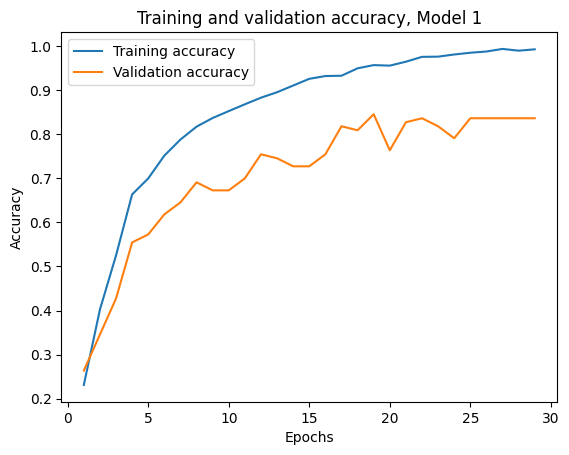

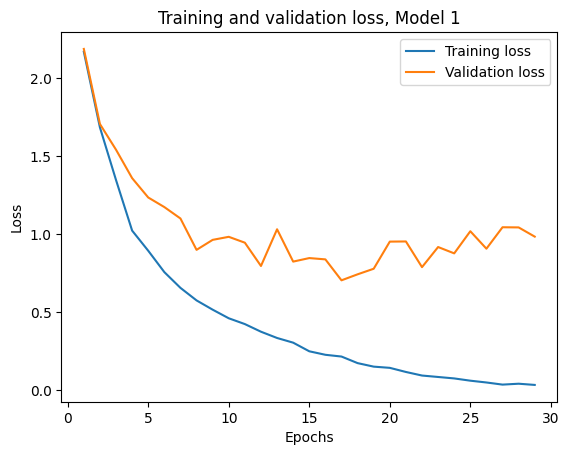

In [34]:
# Plot - Training Accuracy

plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy, Model 1')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/plots/model1_3.jpeg')
plt.show()


# Plot - Training Loss

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss, Model 1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/plots/model1_4.jpeg')
plt.show()

In [35]:
# Average training loss Model 1

model_1_train_loss=[]
model_1_train_loss.append(np.mean(model_history_1[0].history['loss']))
print(np.mean(model_1_train_loss)) #0.6815020

0.45540470270247296


In [36]:
# Average validation loss Model 1

model_1_val_loss=[]
model_1_val_loss.append(np.mean(model_history_1[0].history['val_loss']))
print(np.mean(model_1_val_loss)) #1.20234

1.0374801816611454


### Model 2

Main changes with respect to Model 1: kernel initializer is now glorot normal instead of he uniform, padding is valid instead of same and a Dropout(0.2) layer is added after each max pooling layer

In [37]:
# Definition and architecture of Model 2

def create_model_2():
    model=Sequential()
    model.add(Conv2D(16, (3,3), activation='relu', kernel_initializer='glorot_normal', padding='valid', input_shape=input_shape))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
        
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='glorot_normal', padding='valid'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
       
    model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='glorot_normal', padding='valid'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
        
    model.add(Flatten())
    model.add(Dense(32, activation='relu', kernel_initializer='glorot_normal'))
    model.add(Dense(16, activation='relu', kernel_initializer='glorot_normal'))
    model.add(Dense(11, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=['accuracy'])
    return model

with tf.device(device_name):
  model_2=create_model_2()


# Visualize architecture of Model 2

font = ImageFont.load_default()
visualkeras.layered_view(model_2, legend=True, font=font, 
                         to_file='/content/plots/model2_1.png')

tf.keras.utils.plot_model(model_2, 
                          to_file='/content/plots/model2_2.png',
                          show_shapes=False,
                          show_dtype=False,
                          show_layer_names=False,
                          rankdir="TB",
                          expand_nested=True,
                          dpi=92,
                          layer_range=None,
                          show_layer_activations=True)

print(model_2.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 74, 74, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 32)       

In [38]:
# Define early stopping, callback and fit and evaluate function for Model 2

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

model_checkpoint = ModelCheckpoint('model_2', verbose=1, save_best_only=True)

with tf.device(device_name):
  def fit_and_evaluate(t_x, val_x, t_y, val_y):
      model = None
      model_2 = create_model_2()
      results = model_2.fit(t_x,
                          t_y,
                          epochs=50,
                          batch_size=32,
                          verbose=1,
                          shuffle = True,
                          callbacks=[early_stopping, model_checkpoint],
                          validation_data=(val_x, val_y),)  
      print("Validation Score: ", model_2.evaluate(val_x, val_y))
      return results


# Save the model history in a list after fitting

model_history_2 = [] 

print("Training: ")
model_history_2.append(fit_and_evaluate(X_train, X_valid, y_train, y_valid))
print("======="*12, end="\n\n\n")

Training: 
Epoch 1/50
134/134 [==============================] - ETA: 0s - loss: 2.3207 - accuracy: 0.1392
Epoch 1: val_loss improved from inf to 2.35064, saving model to model_2
134/134 [==============================] - 5s 28ms/step - loss: 2.3207 - accuracy: 0.1392 - val_loss: 2.3506 - val_accuracy: 0.1545
Epoch 2/50
133/134 [============================>.] - ETA: 0s - loss: 2.1389 - accuracy: 0.2284
Epoch 2: val_loss improved from 2.35064 to 2.13473, saving model to model_2
134/134 [==============================] - 4s 28ms/step - loss: 2.1381 - accuracy: 0.2288 - val_loss: 2.1347 - val_accuracy: 0.2273
Epoch 3/50
133/134 [============================>.] - ETA: 0s - loss: 1.6738 - accuracy: 0.4192
Epoch 3: val_loss improved from 2.13473 to 1.74013, saving model to model_2
134/134 [==============================] - 3s 25ms/step - loss: 1.6740 - accuracy: 0.4195 - val_loss: 1.7401 - val_accuracy: 0.3636
Epoch 4/50
133/134 [============================>.] - ETA: 0s - loss: 1.3022 - ac

In [39]:
# Learning curve
history_dict = model_history_2[0].history

# Accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

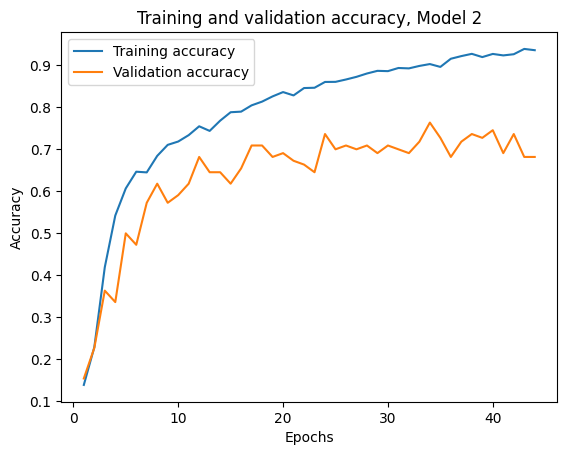

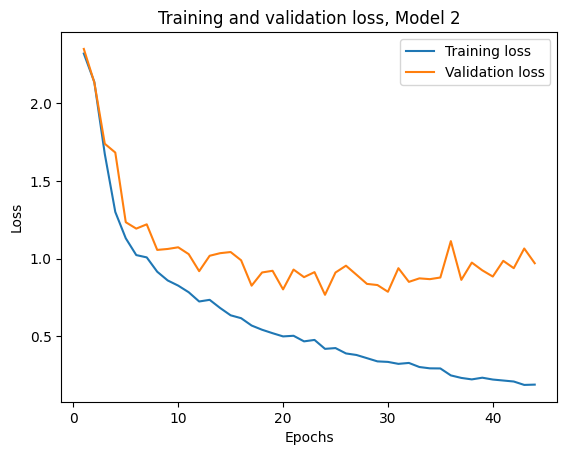

In [40]:
# Plot - Training Accuracy
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy, Model 2')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/plots/model2_3.jpeg')
plt.show()

# Plot - Training Loss
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss, Model 2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/plots/model2_4.jpeg')
plt.show()

In [41]:
# Average training loss

model_2_train_loss=[]
model_2_train_loss.append(np.mean(model_history_2[0].history['loss']))
print(np.mean(model_2_train_loss)) #0.6462

0.6164121519435536


In [42]:
#Average validation loss

model_2_val_loss=[]
model_2_val_loss.append(np.mean(model_history_2[0].history['val_loss']))
print(np.mean(model_2_val_loss)) #0.996066

1.0477936525236478


### Model 3

Model 3 has the following changes with respect to model 2: Optimizer is Adam instead of SG. padding is 'same' again as in model 1, a fourth convolutional layer is added before the flatten layer

In [43]:
# Definition and architecture of model 3

def create_model_3():
    model=Sequential()
    model.add(Conv2D(16, (3,3), activation='relu', kernel_initializer='glorot_normal', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D((2,2)))
            
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='glorot_normal', padding='same'))
    model.add(MaxPooling2D((2,2)))
           
    model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='glorot_normal', padding='same'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='glorot_normal', padding='same'))
    model.add(MaxPooling2D((2,2)))
            
    model.add(Flatten())
    model.add(Dense(32, activation='relu', kernel_initializer='glorot_normal'))
    model.add(Dense(16, activation='relu', kernel_initializer='glorot_normal'))
    model.add(Dense(11, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001,
                                                             beta_1=0.9,
                                                             beta_2=0.999,
                                                             epsilon=1e-07,
                                                             amsgrad=False), metrics=['accuracy'])
    return model

with tf.device(device_name):
  model_3=create_model_3()


# Visualize architecture of Model 3

font = ImageFont.load_default()
visualkeras.layered_view(model_3, legend=True, font=font, 
                         to_file='/content/plots/model1_3.png')

tf.keras.utils.plot_model(model_3, 
                          to_file='/content/plots/model1_3.png',
                          show_shapes=False,
                          show_dtype=False,
                          show_layer_names=False,
                          rankdir="TB",
                          expand_nested=True,
                          dpi=92,
                          layer_range=None,
                          show_layer_activations=True)

print(model_3.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 75, 75, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 37, 37, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 18, 18, 64)      

In [44]:
# Define early stopping, callback and fit and evaluate function for Model 3

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

model_checkpoint = ModelCheckpoint('model_3', verbose=1, save_best_only=True)

with tf.device(device_name):
  def fit_and_evaluate(t_x, val_x, t_y, val_y):
      model = None
      model_3 = create_model_3()
      results = model_3.fit(t_x,
                          t_y,
                          epochs=50,
                          batch_size=32,
                          verbose=1,
                          shuffle = True,
                          callbacks=[early_stopping, model_checkpoint],
                          validation_data=(val_x, val_y),)  
      print("Validation Score: ", model_3.evaluate(val_x, val_y))
      return results


# Save the model history in a list after fitting

model_history_3 = [] 

print("Training: ")
model_history_3.append(fit_and_evaluate(X_train, X_valid, y_train, y_valid))
print("======="*12, end="\n\n\n")

Training: 
Epoch 1/50
134/134 [==============================] - ETA: 0s - loss: 1.7572 - accuracy: 0.4034
Epoch 1: val_loss improved from inf to 1.48018, saving model to model_3
134/134 [==============================] - 4s 27ms/step - loss: 1.7572 - accuracy: 0.4034 - val_loss: 1.4802 - val_accuracy: 0.5455
Epoch 2/50
131/134 [============================>.] - ETA: 0s - loss: 1.0028 - accuracy: 0.6827
Epoch 2: val_loss improved from 1.48018 to 1.19703, saving model to model_3
134/134 [==============================] - 3s 25ms/step - loss: 0.9958 - accuracy: 0.6855 - val_loss: 1.1970 - val_accuracy: 0.6727
Epoch 3/50
132/134 [============================>.] - ETA: 0s - loss: 0.6447 - accuracy: 0.8149
Epoch 3: val_loss improved from 1.19703 to 0.88822, saving model to model_3
134/134 [==============================] - 4s 28ms/step - loss: 0.6468 - accuracy: 0.8149 - val_loss: 0.8882 - val_accuracy: 0.6909
Epoch 4/50
132/134 [============================>.] - ETA: 0s - loss: 0.4845 - ac

In [45]:
# Learning curve
history_dict = model_history_3[0].history

# Accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

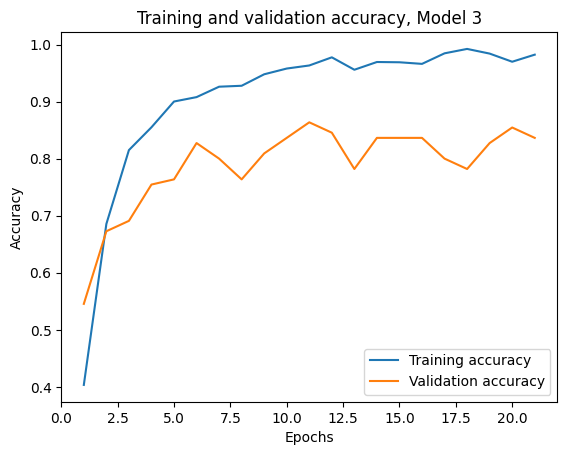

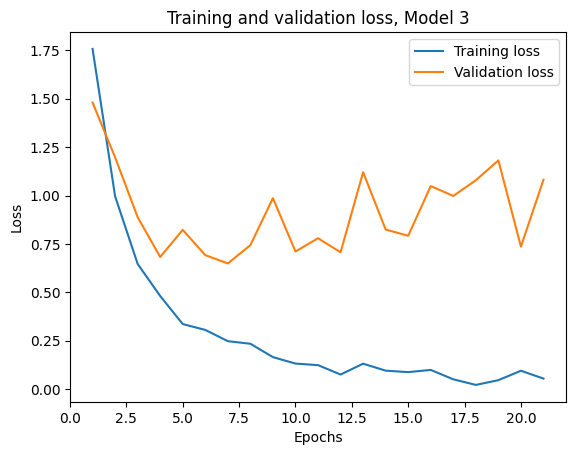

In [46]:
# Plot - Training Accuracy

plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy, Model 3')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/plots/model3_3.jpeg')
plt.show()


# Plot - Training Loss

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss, Model 3')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/plots/model3_4.jpeg')
plt.show()

In [47]:
# Average training loss

model_3_train_loss=[]
model_3_train_loss.append(np.mean(model_history_3[0].history['loss']))
print(np.mean(model_3_train_loss))  #0.23087

0.2946866316986935


In [48]:
# Average validation loss

model_3_val_loss=[]
model_3_val_loss.append(np.mean(model_history_3[0].history['val_loss']))
print(np.mean(model_3_val_loss))  #0.891418

0.9144380348069328


### Model selection

In [49]:
# Validation loss per model

print("Validation Loss - Model 1: ", np.mean(model_1_val_loss)) 
print("Validation Loss - Model 2: ",np.mean(model_2_val_loss)) 
print("Validation Loss - Model 3: ",np.mean(model_3_val_loss)) 

Validation Loss - Model 1:  1.0374801816611454
Validation Loss - Model 2:  1.0477936525236478
Validation Loss - Model 3:  0.9144380348069328


In [50]:
# Test loss - winner model

model = load_model('model_3')

print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)
#0.4838, 0.899999

Evaluate on test data
4/4 [==============================] - 0s 8ms/step - loss: 0.5197 - accuracy: 0.8455
test loss, test acc: [0.519687294960022, 0.8454545736312866]


In [51]:
# Confusion matrix - winner model

preds = model.predict(X_test)

matrix = confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1))
matrix

array([[ 8,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0],
       [ 0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  8,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  8,  2,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  9,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  1,  0,  0,  8,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 10,  0,  0],
       [ 0,  2,  0,  0,  0,  0,  0,  0,  0,  8,  0],
       [ 0,  0,  0,  0,  2,  4,  0,  0,  0,  0,  4]])

In [52]:
# Precision and recall - winner model

report_model = classification_report(y_test.argmax(axis=1), preds.argmax(axis=1), target_names=categories, output_dict=True)
report_model = pd.DataFrame(report_model).transpose().round(2)
print(report_model)

                    precision  recall  f1-score  support
Alstonia Scholaris       0.89    0.80      0.84    10.00
Arjun                    0.77    1.00      0.87    10.00
Basil                    1.00    0.80      0.89    10.00
Chinar                   0.91    1.00      0.95    10.00
Gauva                    0.67    0.80      0.73    10.00
Jamun                    0.62    1.00      0.77    10.00
Jatropha                 1.00    0.90      0.95    10.00
Lemon                    0.80    0.80      0.80    10.00
Mango                    1.00    1.00      1.00    10.00
Pomegranate              1.00    0.80      0.89    10.00
Pongamia Pinnata         1.00    0.40      0.57    10.00
accuracy                 0.85    0.85      0.85     0.85
macro avg                0.88    0.85      0.84   110.00
weighted avg             0.88    0.85      0.84   110.00


In [53]:
print(report_model.to_latex(position='H', bold_rows=True, float_format="{:.2f}".format, label='report_model', caption='Classification Report, winner Model'))

\begin{table}[H]
\centering
\caption{Classification Report, winner Model}
\label{report_model}
\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &  support \\
\midrule
\textbf{Alstonia Scholaris} &       0.89 &    0.80 &      0.84 &    10.00 \\
\textbf{Arjun             } &       0.77 &    1.00 &      0.87 &    10.00 \\
\textbf{Basil             } &       1.00 &    0.80 &      0.89 &    10.00 \\
\textbf{Chinar            } &       0.91 &    1.00 &      0.95 &    10.00 \\
\textbf{Gauva             } &       0.67 &    0.80 &      0.73 &    10.00 \\
\textbf{Jamun             } &       0.62 &    1.00 &      0.77 &    10.00 \\
\textbf{Jatropha          } &       1.00 &    0.90 &      0.95 &    10.00 \\
\textbf{Lemon             } &       0.80 &    0.80 &      0.80 &    10.00 \\
\textbf{Mango             } &       1.00 &    1.00 &      1.00 &    10.00 \\
\textbf{Pomegranate       } &       1.00 &    0.80 &      0.89 &    10.00 \\
\textbf{Pongamia Pinnata  } &       1.00 &

<ipython-input-53-20291773e45f>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(report_model.to_latex(position='H', bold_rows=True, float_format="{:.2f}".format, label='report_model', caption='Classification Report, winner Model'))
